<a href="https://colab.research.google.com/github/jatan36/Code_Pudding/blob/main/august_code_pudding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The growth of music streaming platforms such as Spotify has generated massive amounts of data that can be used to understand what makes a song popular. Popularity on Spotify is measured on a scale of 0–100 and is influenced by a variety of factors, ranging from audio characteristics to user behavior. In this project, we focused on predicting a track’s popularity using only its **audio features** (e.g., danceability, energy, tempo, acousticness, valence, loudness) as provided in the **Ultimate Spotify Tracks Database** (232k tracks).  

The central objective of this study was to build and evaluate **machine learning models in PyTorch** capable of predicting popularity based on audio features alone. By combining exploratory data analysis (EDA), preprocessing, and multiple neural network architectures, we aimed to assess whether audio characteristics can serve as reliable predictors of popularity, and to provide actionable insights for both Spotify and artists.  

---

## Methodology

The project followed a structured workflow, moving from data collection and exploration to model development and evaluation:  

1. **Data Collection & Preparation**  
   - Dataset: *Ultimate Spotify Tracks Database* from Kaggle (≈232,000 tracks).  
   - Preprocessing steps included removing duplicates, handling missing values, and selecting relevant **numeric audio features**.  
   - Features were normalized using **MinMaxScaler** to ensure consistency in neural network training.  

2. **Exploratory Data Analysis (EDA)**  
   - Examined distributions of all numeric features using histograms and boxplots.  
   - Identified skewed features (instrumentalness, speechiness, liveness) and outliers (duration, tempo).  
   - Computed correlations: popularity correlated most with **loudness (0.36)**, **danceability (0.26)**, and **energy (0.25)**, while **acousticness (-0.38)** correlated negatively.  
   - Found that no single feature strongly predicts popularity, suggesting the need for nonlinear models.  

3. **Data Splitting**  
   - Data was divided into **training (80% = 186,180 samples)**, **validation (10% = 23,272 samples)**, and **test sets (10% = 23,273 samples)**.  
   - A **custom PyTorch Dataset class** and **DataLoaders** (batch size = 64) were implemented for efficient mini-batch processing.  

4. **Model Development**  
   - Baseline model: a **Multi-Layer Perceptron (MLP)** with two hidden layers (64 → 32 neurons, ReLU activations).  
   - Trained using **Adam optimizer (lr = 0.001)** and **MSELoss**.  
   - Additional architectures tested:  
     - **MLP1Layer** (simpler model).  
     - **MLP2Layer** (baseline).  
     - **MLP3LayerDropout** (regularization to reduce overfitting).  
     - **MLP2LayerBatchNorm** (stabilization and faster convergence).  

5. **Evaluation**  
   - Models were trained for 10 epochs, tracking **training and validation loss**.  
   - Performance measured using **Mean Squared Error (MSE)** on validation and test sets.  
   - Best performance achieved with **MLP2LayerBatchNorm** (Validation Loss = **212.4**).  

---

### Summary of Approach
By integrating **EDA, preprocessing, and neural network experimentation**, the project provided insights into the extent to which audio features alone can predict popularity. While results show only moderate accuracy (MSE ~212–233), they highlight the importance of feature scaling, regularization, and model architecture selection, as well as the potential for integrating richer datasets in the future.


In [ ]:
! pip install opendatasets --quiet

In [ ]:
! pip install torchsummary --quiet

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import opendatasets as od
import os
import time
import random

import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam

from torchvision.transforms import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from skimage.transform import resize

In [ ]:
import opendatasets as od
od.download("http://kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ewmacdougall
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db


100%|██████████| 15.5M/15.5M [00:00<00:00, 244MB/s]

In [ ]:
df = pd.read_csv(filepath_or_buffer='./ultimate-spotify-tracks-db/SpotifyFeatures.csv')

## Set seed and GPU

In [ ]:
os.cpu_count()

2

In [ ]:
device = ''
print("Torch version:", torch.__version__)
print("Cuda Available:", torch.cuda.is_available())
print("Cuda Built:", torch.backends.cuda.is_built())


print("MPS Available:", torch.backends.mps.is_available())
print("MPS Built:", torch.backends.mps.is_built())

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("Cuda not available on this machine.")
    print("MPS not available on this machine.")
    device = 'cpu'
print(f"Device is set to {device}.")

Torch version: 2.6.0+cu124
Cuda Available: False
Cuda Built: True
MPS Available: False
MPS Built: False
Cuda not available on this machine.
MPS not available on this machine.
Device is set to cpu.


In [ ]:
def set_seed(seed=42):
    """Set seed for reproducibility across Python, NumPy, and PyTorch (CPU, CUDA, MPS)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print("CUDA seed set.")

    elif torch.backends.mps.is_available():
        # MPS does not support full reproducibility guarantees. No additional MPS-specific seed functions exist yet
        print("MPS backend detected. Note: Determinism is limited on macOS MPS.")

    print(f"Seed set to {seed} for reproducibility (best effort on available hardware).")

# Invoke
SEED=42
set_seed(SEED)

Seed set to 42 for reproducibility (best effort on available hardware).


## Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [ ]:
df.describe(include='object')

genre     artist_name track_name                track_id     key  \
count   232725          232725     232724                  232725  232725   
unique      27           14564     148614                  176774      12   
top     Comedy  Giuseppe Verdi       Home  6sVQNUvcVFTXvlk3ec0ngd       C   
freq      9681            1394        100                       8   27583   

          mode time_signature  
count   232725         232725  
unique       2              5  
top      Major            4/4  
freq    151744         200760

In [ ]:
df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isna().sum()

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [ ]:
df.drop_duplicates(inplace=True)

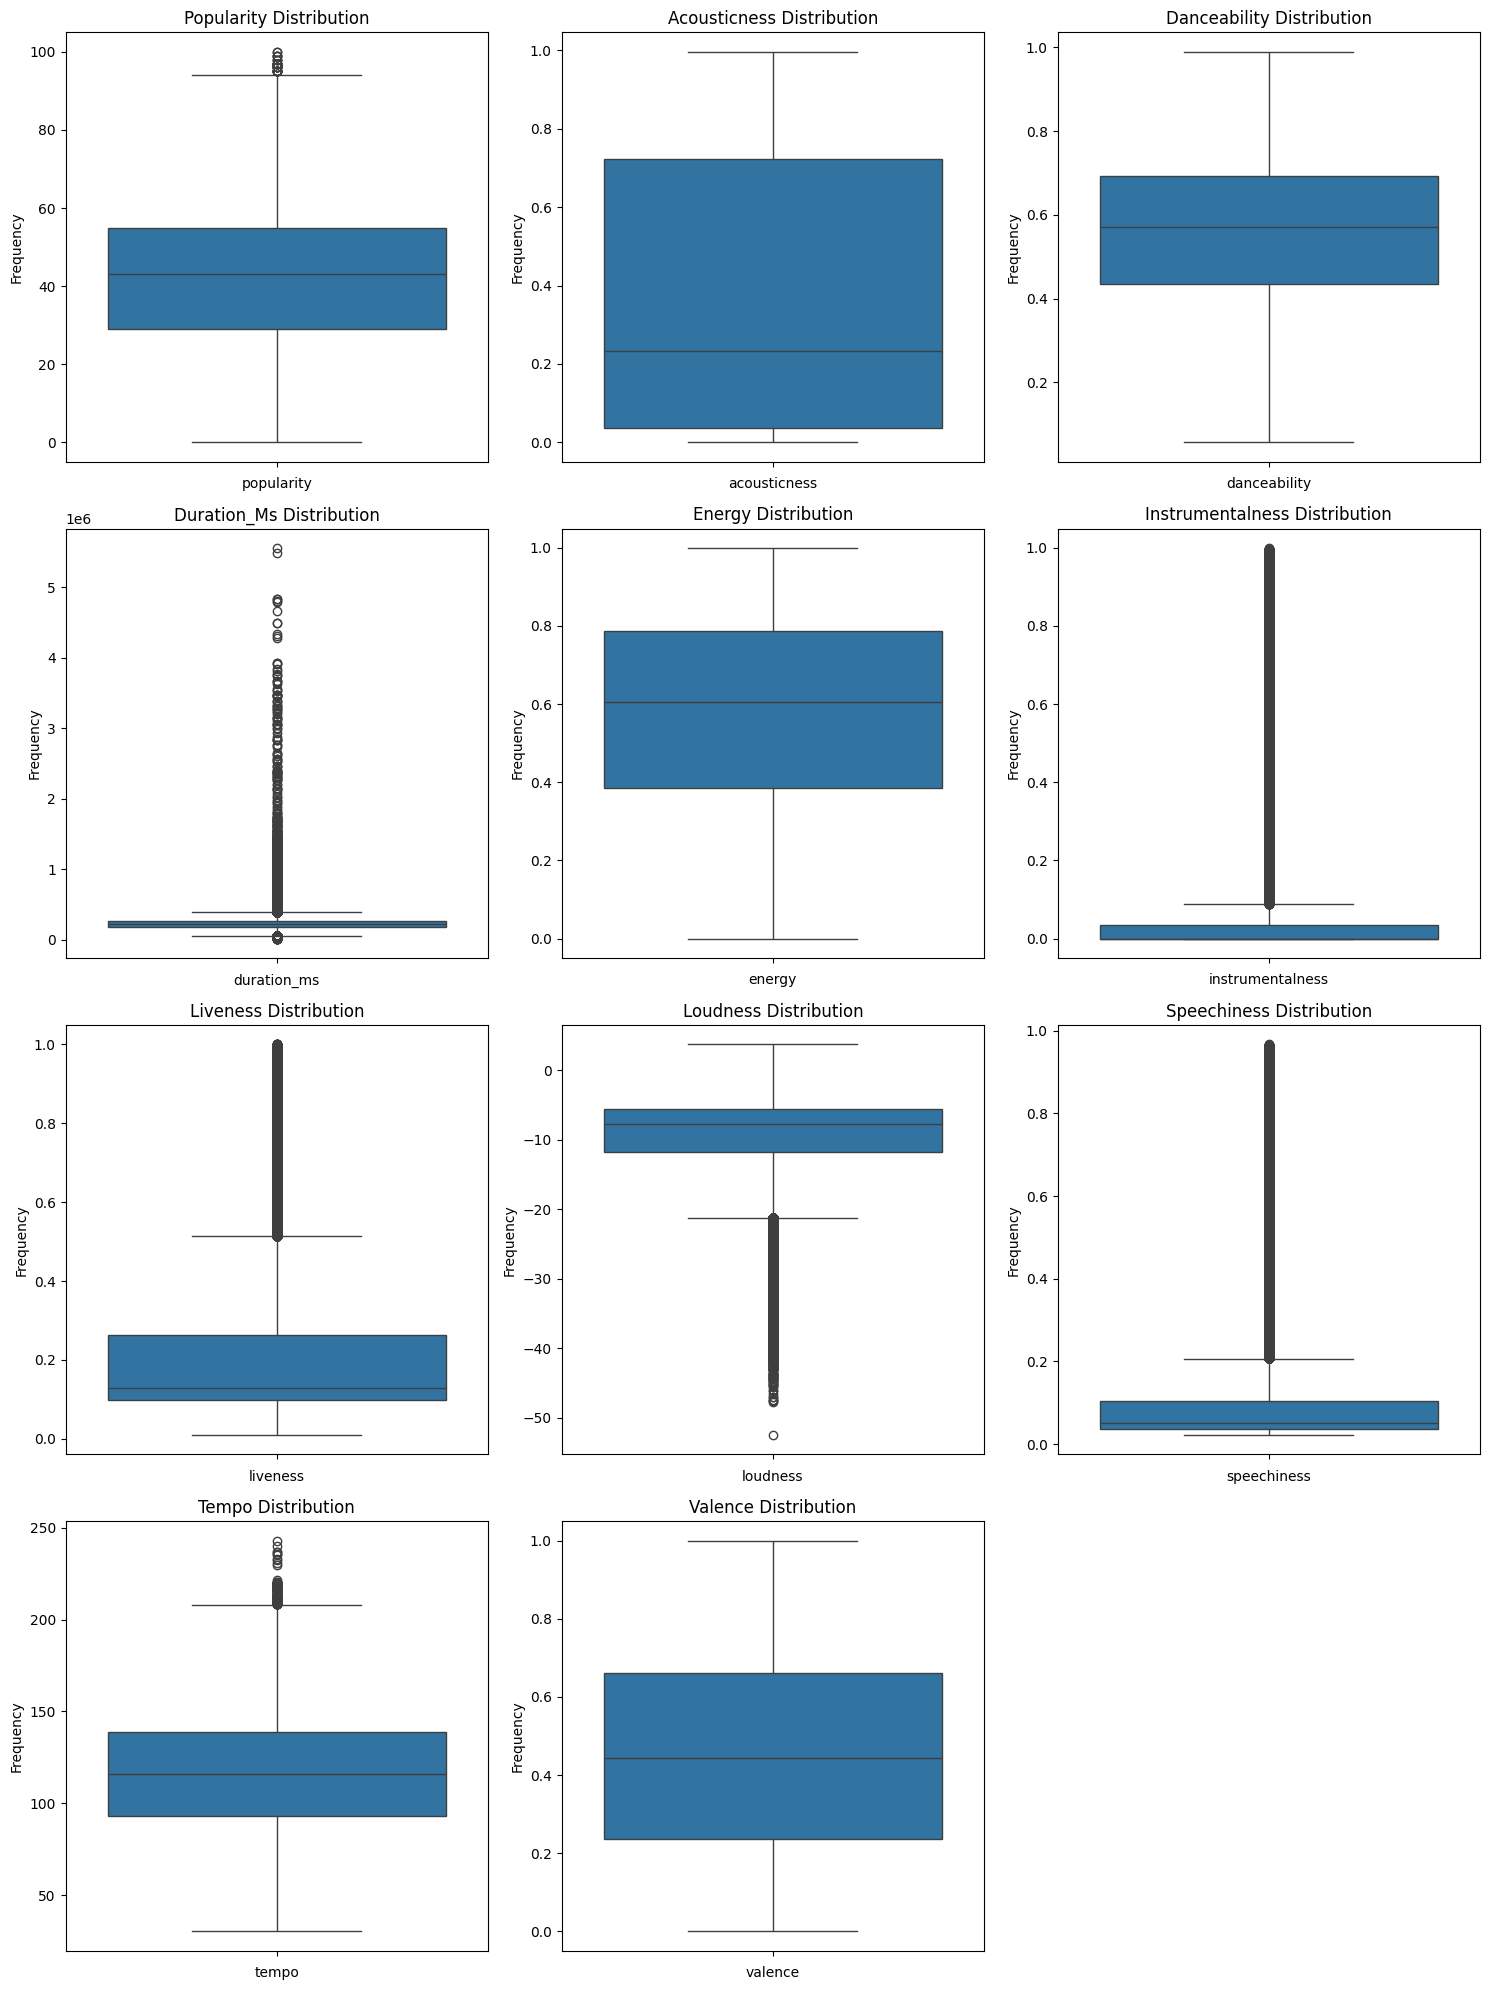

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns

# Set up the number of rows and columns for subplots
n = len(numeric_columns)
cols = 3  # Number of columns for subplots
rows = (n + cols - 1) // cols  # Calculate the number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate
i = 0

# Plot a boxplot for each numeric column
for i, col in enumerate(numeric_columns):
    sns.boxplot(df[col], ax=axes[i], patch_artist=True)  # Specify ax for each boxplot
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col.title()} Distribution')

# Hide any extra subplots if the numeric columns are not divisible by three.
for j in range(i + 1, len(axes)):
   axes[j].axis('off')

# Adjust the layout to ensure there's no overlap
plt.tight_layout()

# Show the figure
plt.show()

# Feature Distribution Analysis – Spotify Dataset (Boxplots)

## 1. Popularity
- Distribution is **skewed toward lower–mid popularity values**.  
- Few songs reach very high popularity (>80), suggesting **class imbalance** in the target.  

## 2. Acousticness
- Wide spread, but most tracks cluster at **very low acousticness values**.  
- Indicates that the dataset is dominated by electronically produced or non-acoustic songs.  

## 3. Danceability
- Fairly balanced distribution centered around **0.5–0.7**.  
- Suggests most tracks are moderately danceable.  

## 4. Duration (ms)
- Many extreme **outliers** (very long songs).  
- Typical songs cluster around standard track lengths (~3–5 minutes).  

## 5. Energy
- Skewed toward **higher values (0.6–0.8)**.  
- Most tracks are energetic, with fewer quiet/low-energy songs.  

## 6. Instrumentalness
- Highly skewed → the majority of songs have **very low instrumentalness**.  
- Few songs are fully instrumental.  

## 7. Liveness
- Skewed toward low values.  
- Indicates most tracks are recorded in studios, not live.  

## 8. Loudness
- Centered around **-10 dB**, with outliers extending much lower.  
- Matches typical loudness of commercial music.  

## 9. Speechiness
- Strongly skewed toward **near zero**.  
- Most tracks are music-heavy rather than spoken word/rap.  

## 10. Tempo
- Distribution centered near **120 BPM** (common tempo in popular music).  
- Outliers exist, but tempo is fairly normally distributed.  

## 11. Valence
- Broad spread across the 0–1 scale.  
- Many tracks sit in the mid-range, reflecting a mix of positive and negative moods.  

---

### **Key Insights**
- Popularity is **imbalanced**, with few highly popular songs.  
- Features like **instrumentalness, speechiness, and liveness** are highly skewed, which may require **log transformation or scaling**.  
- Outliers (especially in **duration** and **loudness**) may distort training and should be handled carefully.  


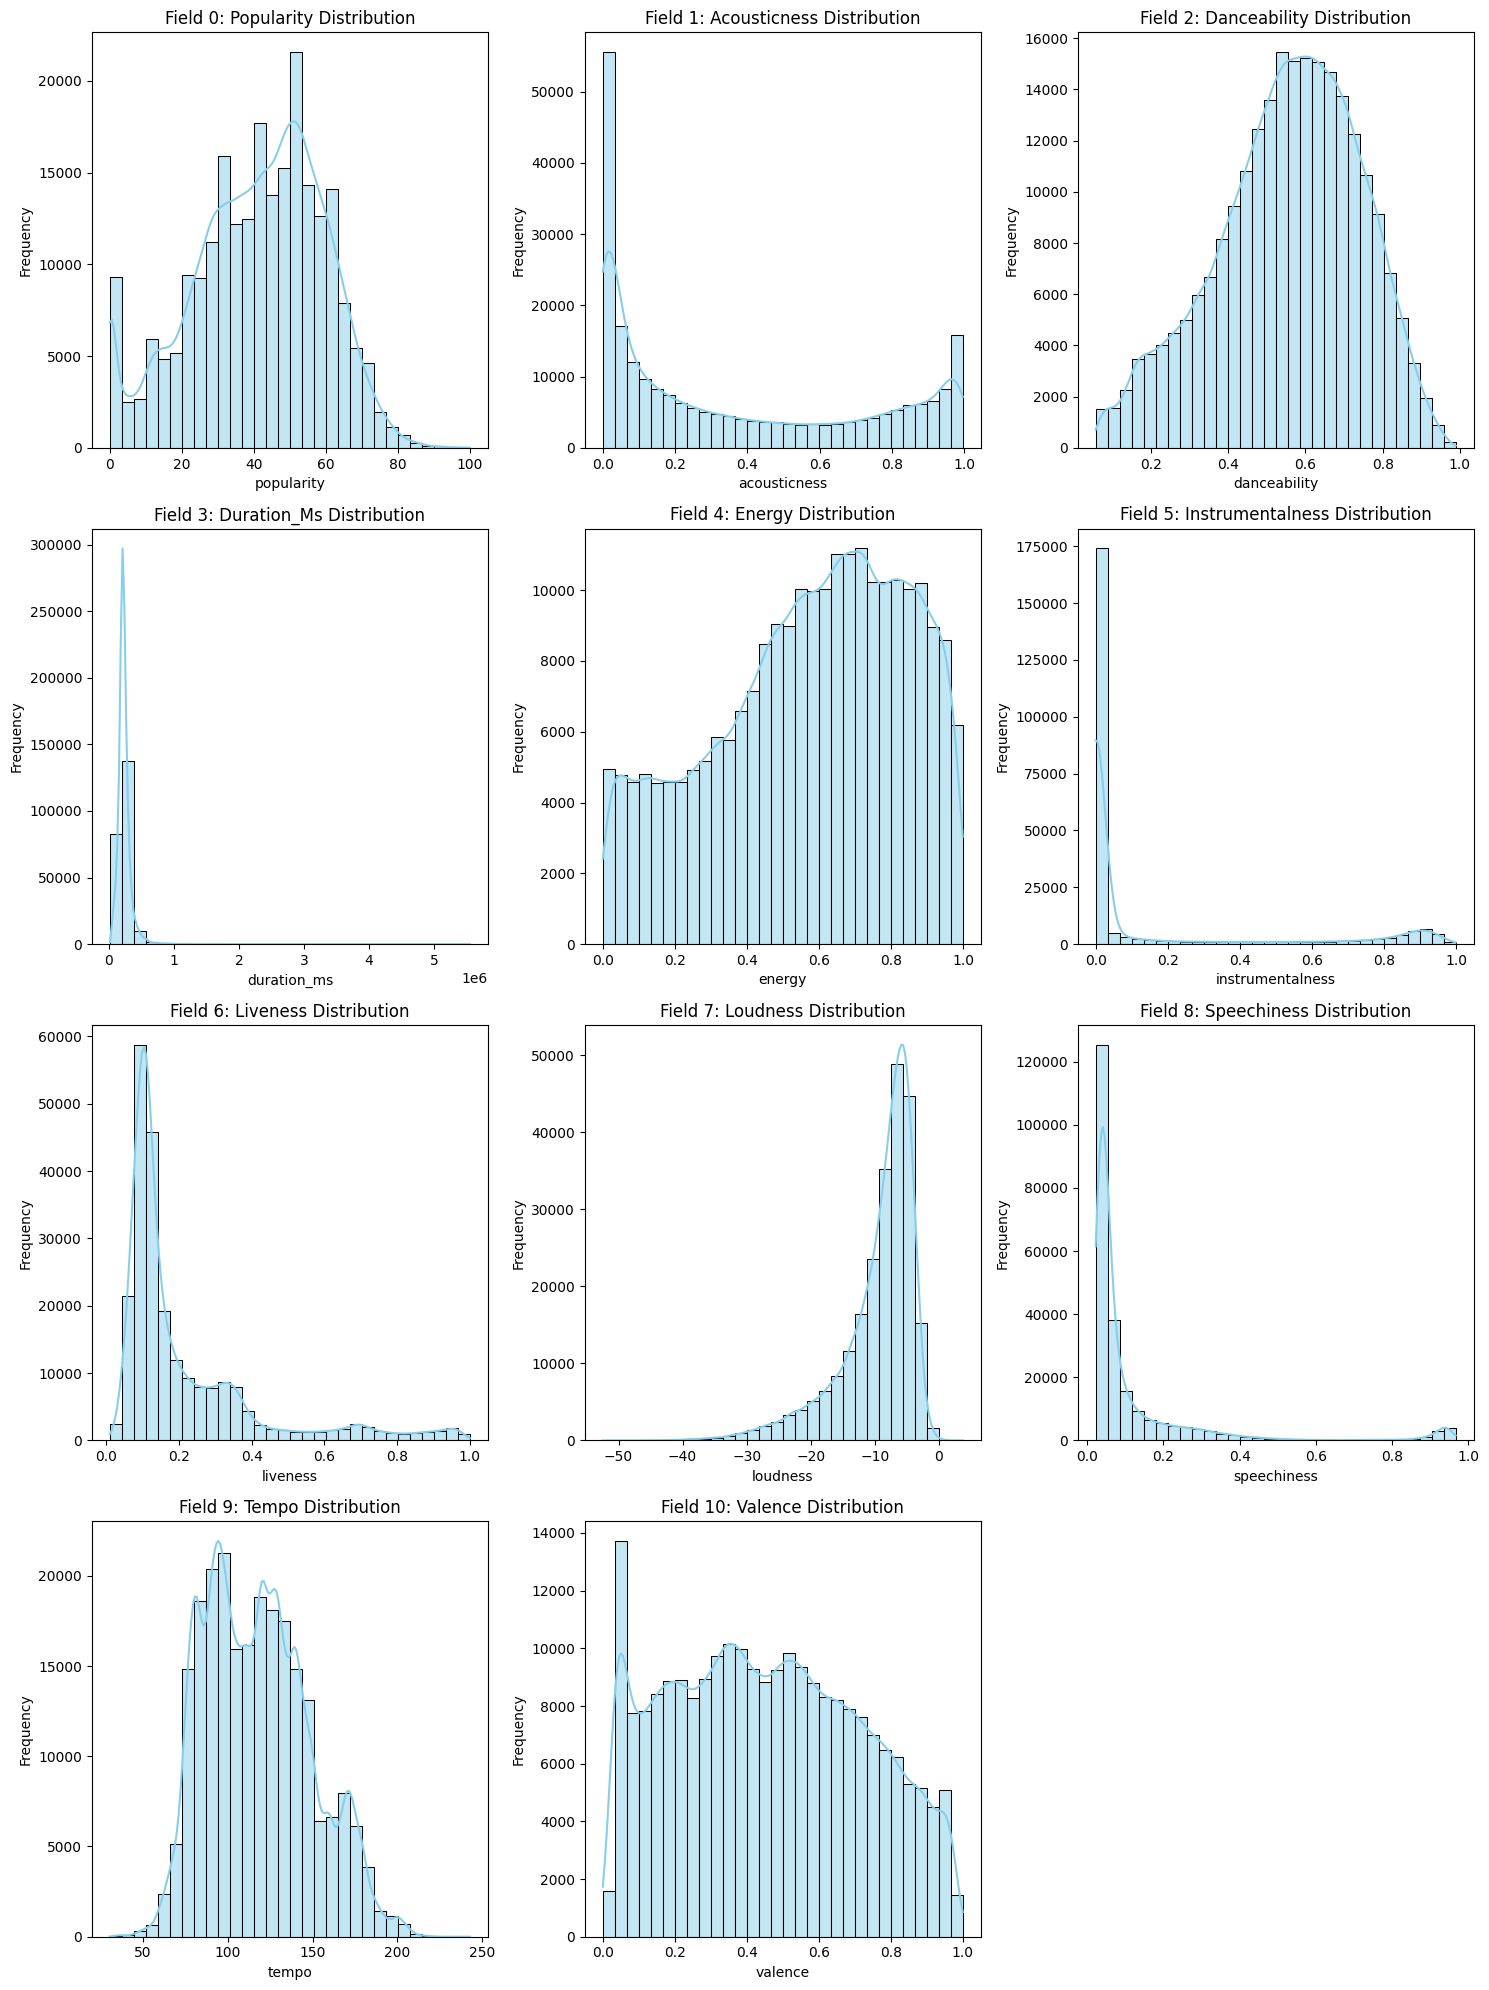

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns  # Select only numeric columns

# Set up the number of rows and columns for subplots
n = len(numeric_columns)
cols = 3  # Number of columns for subplots
rows = (n + cols - 1) // cols  # Calculate the number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate
i = 0

# Plot a histogram for each numeric column
for i, col in enumerate(numeric_columns):
    bins = 30
    if df[col].nunique() < bins and df[col].nunique() >= 1:
        bins = df[col].nunique()
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Field {i}: {col.title()} Distribution')

# Hide any extra subplots if the numeric columns are not divisible by three.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to ensure there's no overlap
plt.tight_layout()

# Show the figure
plt.show()

# Feature Distribution Analysis – Spotify Dataset (Histograms)

## 1. Popularity
- Roughly bell-shaped distribution, centered around **40–60**.  
- Few songs exceed 80, confirming **imbalance in highly popular tracks**.  

## 2. Acousticness
- Strongly **bimodal**: many songs are either highly acoustic or very low in acousticness.  
- Indicates two main categories: acoustic vs. electronic/produced tracks.  

## 3. Danceability
- Centered around **0.6**, slightly right-skewed.  
- Most tracks are moderately to highly danceable.  

## 4. Duration (ms)
- Heavy right skew with **extreme outliers**.  
- Majority of songs are in the **2–5 minute range**, but some long tracks distort the scale.  

## 5. Energy
- Skewed toward higher values (0.6–0.9).  
- Most songs are energetic, fewer tracks are quiet/low-energy.  

## 6. Instrumentalness
- Extremely right-skewed: most songs have very low instrumentalness.  
- Only a small fraction of tracks are fully instrumental.  

## 7. Liveness
- Skewed toward low values (<0.3).  
- Suggests most recordings are **studio-produced**, with fewer live performances.  

## 8. Loudness
- Normal-like distribution centered around **-10 dB**.  
- Matches expected commercial track loudness.  

## 9. Speechiness
- Strongly right-skewed: majority of tracks have very low speechiness.  
- A minority of tracks (rap, spoken word) show higher values.  

## 10. Tempo
- Peaks around **100–130 BPM**, aligning with common tempos in pop and dance music.  
- Distribution is roughly normal with some variability.  

## 11. Valence
- Broadly spread between 0 and 1, but slightly left-skewed.  
- Indicates songs trend toward **lower/mid emotional positivity**.  

---

### **Key Takeaways**
- **Popularity** is imbalanced → most songs are moderately popular, very few are extreme hits.  
- Features like **instrumentalness, speechiness, and liveness** are highly skewed → may require transformation (e.g., log scaling).  
- Outliers in **duration** and **tempo** could impact model training and should be handled.  
- Overall, distributions show meaningful variation, but some features are heavily skewed and will need preprocessing before modeling.  


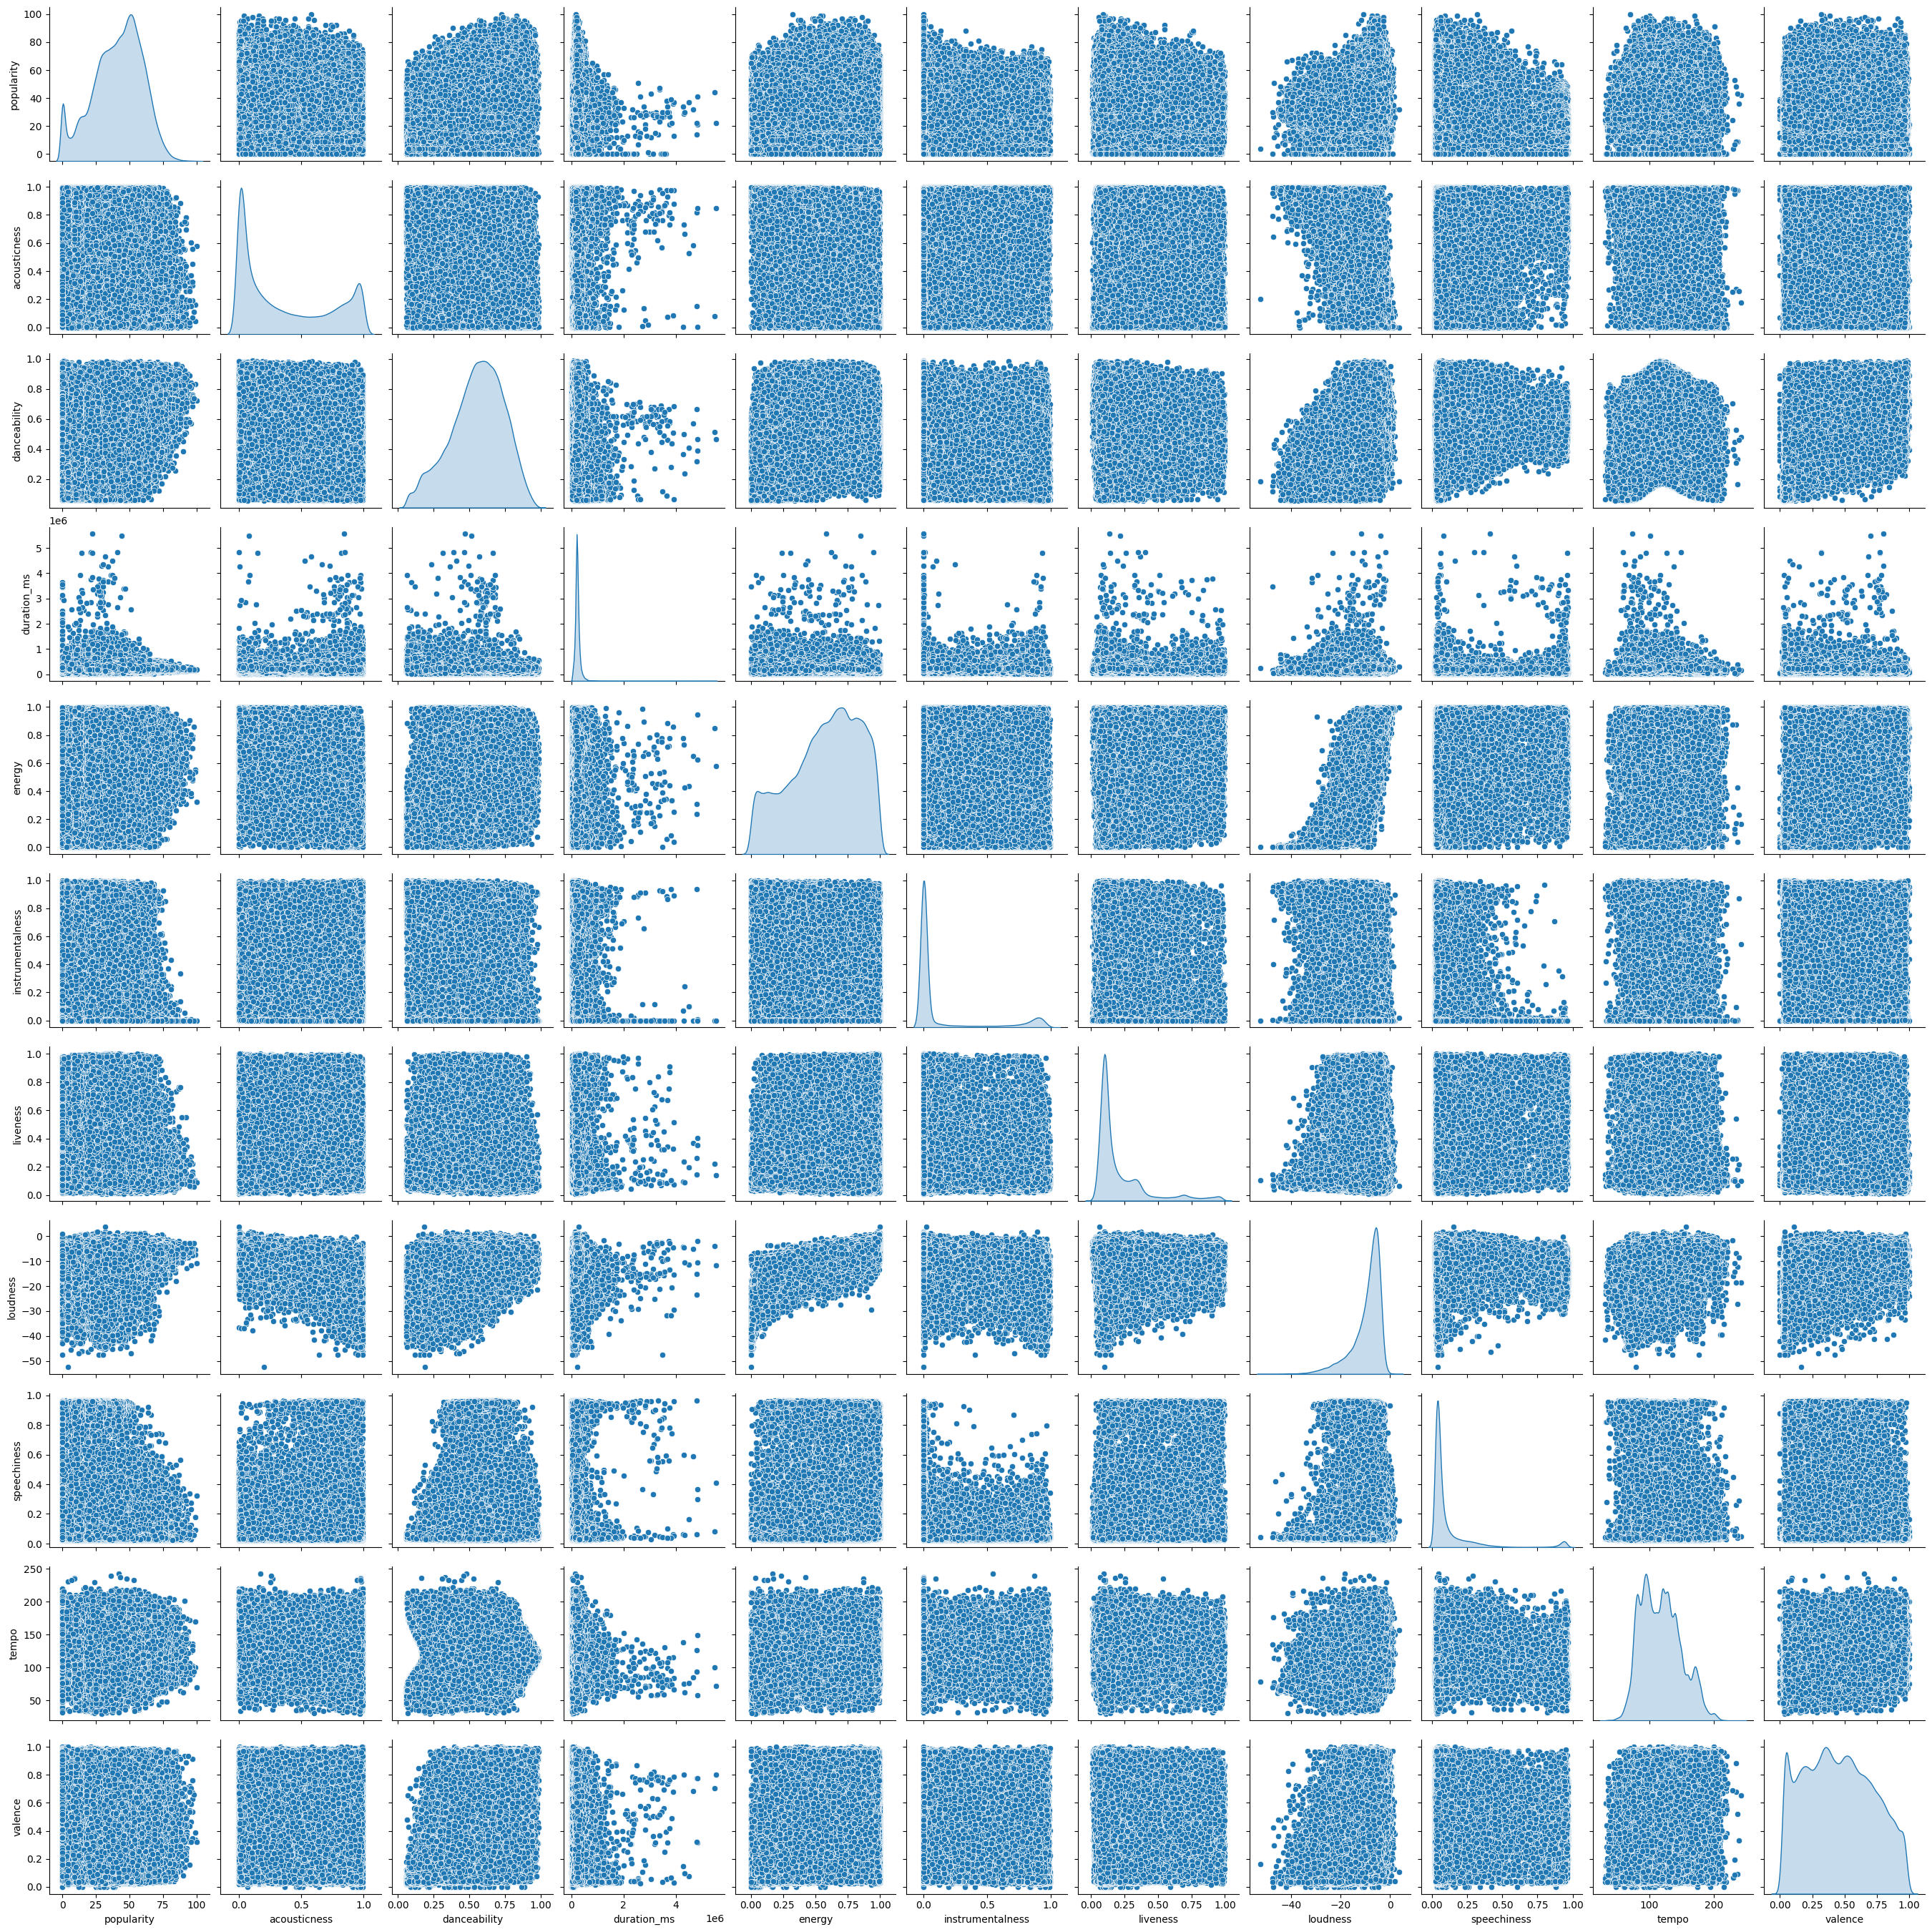

In [ ]:
sns.pairplot(data=df, diag_kind='kde', kind='scatter')

## 1. Distribution of Features
- Many audio features (e.g., **danceability, energy, valence**) show roughly uniform or wide distributions, suggesting good coverage across different song types.  
- Some features like **acousticness** and **speechiness** are heavily skewed, meaning most songs have low values with a few extreme outliers.  
- **Popularity** (target) is not evenly distributed – it looks concentrated in the lower–mid range, with fewer highly popular tracks. This imbalance may affect model performance.  

## 2. Relationships Between Features
- **Energy vs. Loudness** → strong positive relationship (louder songs tend to have higher energy).  
- **Danceability vs. Valence** → slight positive trend (more danceable songs tend to feel happier).  
- **Tempo vs. Other Features** → little to no clear correlation (tempo is spread across values regardless of popularity or danceability).  
- **Acousticness vs. Energy** → negative relationship (acoustic songs tend to be lower in energy).  

## 3. Popularity vs. Features
- No strong linear correlation between popularity and single features (scatter plots look widely spread).  
- Weak patterns suggest that popularity is influenced by **a complex combination of features**, not a single attribute.  
- Outliers: some very unpopular tracks have extreme feature values (e.g., very high speechiness or acousticness).  



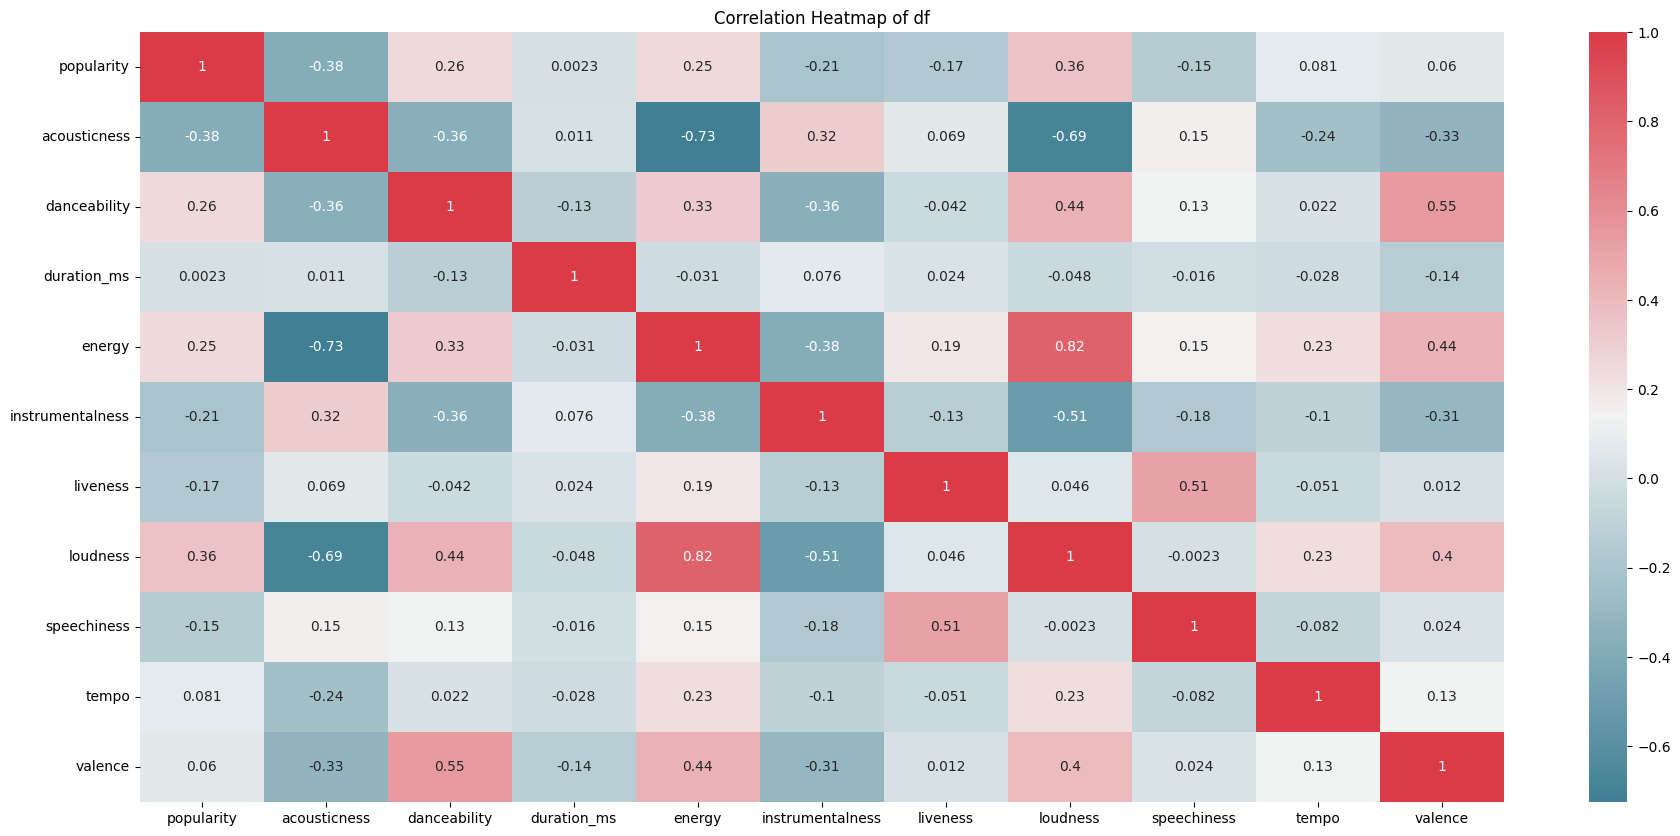

In [ ]:
numerical_columns = df.select_dtypes(include=['number'])
corr = numerical_columns.corr()
plt.figure(figsize=(22, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.title(label='Correlation Heatmap of df')
plt.show()

# Correlation Heatmap Analysis – Spotify Dataset

## 1. Popularity Correlations
- **Positive correlations**:  
  - Loudness (0.36) → louder songs tend to be more popular.  
  - Danceability (0.26) → more danceable tracks are slightly more popular.  
  - Energy (0.25) → energetic songs show mild popularity gains.  
- **Negative correlations**:  
  - Acousticness (-0.38) → acoustic songs are generally less popular.  
  - Instrumentalness (-0.21) → highly instrumental tracks are less popular.  
  - Speechiness (-0.15) → songs with a lot of spoken words tend to score lower in popularity.  

## 2. Strong Feature Relationships
- **Energy & Loudness** → very strong positive correlation (0.82).  
- **Acousticness & Energy** → strong negative correlation (-0.73).  
- **Acousticness & Loudness** → strong negative correlation (-0.69).  
- **Danceability & Valence** → moderate positive correlation (0.55).  
- **Liveness & Speechiness** → moderate positive correlation (0.51).


In [ ]:
corr

popularity  acousticness  danceability  duration_ms  \
popularity          1.000000     -0.381295      0.256564     0.002348   
acousticness       -0.381295      1.000000     -0.364546     0.011203   
danceability        0.256564     -0.364546      1.000000    -0.125781   
duration_ms         0.002348      0.011203     -0.125781     1.000000   
energy              0.248922     -0.725576      0.325807    -0.030550   
instrumentalness   -0.210983      0.316154     -0.364941     0.076021   
liveness           -0.167995      0.069004     -0.041684     0.023783   
loudness            0.363011     -0.690202      0.438668    -0.047618   
speechiness        -0.151076      0.150935      0.134560    -0.016171   
tempo               0.081039     -0.238247      0.021939    -0.028456   
valence             0.060076     -0.325798      0.547154    -0.141811   

                    energy  instrumentalness  liveness  loudness  speechiness  \
popularity        0.248922         -0.210983 -0.167995  0.363011    -0.151076   
acousticness     -0.725576          0.316154  0.069004 -0.690202     0.150935   
danceability      0.325807         -0.364941 -0.041684  0.438668     0.134560   
duration_ms      -0.030550          0.076021  0.023783 -0.047618    -0.016171   
energy            1.000000         -0.378957  0.192801  0.816088     0.145120   
instrumentalness -0.378957          1.000000 -0.134198 -0.506320    -0.177147   
liveness          0.192801         -0.134198  1.000000  0.045686     0.510147   
loudness          0.816088         -0.506320  0.045686  1.000000    -0.002273   
speechiness       0.145120         -0.177147  0.510147 -0.002273     1.000000   
tempo             0.228774         -0.104133 -0.051355  0.228364    -0.081541   
valence           0.436771         -0.307522  0.011804  0.399901     0.023842   

                     tempo   valence  
popularity        0.081039  0.060076  
acousticness     -0.238247 -0.325798  
danceability      0.021939  0.547154  
duration_ms      -0.028456 -0.141811  
energy            0.228774  0.436771  
instrumentalness -0.104133 -0.307522  
liveness         -0.051355  0.011804  
loudness          0.228364  0.399901  
speechiness      -0.081541  0.023842  
tempo             1.000000  0.134857  
valence           0.134857  1.000000

# EDA Conclusion

The exploratory data analysis reveals that while audio features provide valuable information about songs, **no single feature strongly predicts popularity**. Instead, popularity is influenced by a **combination of multiple attributes** such as loudness, energy, danceability, and acousticness.  

Several important patterns emerged:  
- **Feature distributions are uneven**: many features (instrumentalness, speechiness, liveness) are highly skewed, requiring normalization or transformation.  
- **Correlations exist**: energy and loudness are strongly correlated, as are danceability and valence. Popularity itself shows only **weak-to-moderate correlations** with individual features.  
- **Target imbalance**: the popularity variable is concentrated in the mid-range, with relatively few tracks achieving very high popularity scores. This imbalance could make prediction more challenging.  
- **Outliers**: features like duration and tempo contain extreme values that may need filtering or scaling to avoid distorting model training.  

### **Final Insight**
The EDA suggests that predicting popularity will require a **nonlinear approach** capable of capturing complex feature interactions. A neural network model is well-suited for this task, but careful **feature preprocessing, outlier handling, and attention to data imbalance** will be critical for improving accuracy.  


In [ ]:
### Anomaly Detection

### Anomaly Detection

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest

# I create data_df to prevent overwriting original dataset
data_df = df.select_dtypes(include=['number']).copy()
print("Data shape:", data_df.shape)
print("-" * 50)

# Anomaly Detection using K-Nearest Neighbors (KNN)
print("Running Anomaly Detection with K-Nearest Neighbors...")
n_neighbors = 5
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(data_df, data_df['popularity'])
distances, index = knn_model.kneighbors(data_df)
knn_scores = distances[:, n_neighbors-1]
threshold = np.percentile(knn_scores, 95)

knn_anomalies = data_df[knn_scores > threshold]
print(f"KNN found {len(knn_anomalies)} anomalies. This represents {(len(knn_anomalies) / data_df.shape[0])*100:.2f}% of data.")
print("-" * 80)

# Anomaly Detection using Isolation Forest
print("Running Anomaly Detection with Isolation Forest...")
isolation_forest = IsolationForest(contamination='auto', random_state=42)

# Fit the model and get the predictions for anomalyies
preds = isolation_forest.fit_predict(data_df)
iso_anomalies = data_df[preds == -1]
print(f"Isolation Forest found {len(iso_anomalies)} anomalies. This represents {(len(iso_anomalies) / data_df.shape[0])*100:.2f}% of data.")
print("-" * 80)

# Anomaly Detection using IQR (Interquartile Range)
print("Running Anomaly Detection with IQR...")

q1 = data_df.quantile(0.25)
q3 = data_df.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

iqr_anomalies = data_df[~((data_df > lower_bound) & (data_df < upper_bound)).all(axis=1)]

print(f"IQR found {len(iqr_anomalies)} anomalies. This represents {(len(iqr_anomalies) / data_df.shape[0])*100:.2f}% of data.")
print("-" * 80)


Data shape: (232725, 11)
--------------------------------------------------
Running Anomaly Detection with K-Nearest Neighbors...
KNN found 11637 anomalies. This represents 5.00% of data.
--------------------------------------------------------------------------------
Running Anomaly Detection with Isolation Forest...
Isolation Forest found 48979 anomalies. This represents 21.05% of data.
--------------------------------------------------------------------------------
Running Anomaly Detection with IQR...
IQR found 98708 anomalies. This represents 42.41% of data.
--------------------------------------------------------------------------------


In [ ]:
(df.select_dtypes(include=['number']).drop(index=knn_anomalies.index)).shape

(221088, 11)

In [ ]:
# numerical_columns = (df.select_dtypes(include=['number']).drop(index=iqr_anomalies.index))

The following modeling has been run with three other iterations of the dataset. These iterations had dropped the points listed by knn, IQR, or IsolationForests as anomalies. They all performed worst than the original dataset after RobustScaling.

## ML Premodeling

In [ ]:
# Identify Features and Target, and Scale Features

X = numerical_columns.drop(columns=["popularity"]).values
y = numerical_columns["popularity"].values



scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the dataset into a training set (80%), test set (10%) and validation set (10%)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

print(X_train.shape, X_test.shape, X_val.shape)

(186180, 10) (23273, 10) (23272, 10)


In [ ]:
# Custom Numeric Dataset
class CustomNumericDataset(Dataset):
    def __init__(self, X, y, device='cpu'):
      self.X = torch.tensor(X, dtype=torch.float32).to(device)
      self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [ ]:
# Create datasets and dataloaders for train, test and val subsets
device = 'cpu'
batch_size = 64

train_dataset = CustomNumericDataset(X_train, y_train, device=device)
val_dataset   = CustomNumericDataset(X_val, y_val, device=device)
test_dataset  = CustomNumericDataset(X_test, y_test, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## ML Model Building:

In [ ]:
# Try different appropriate layer types and try different numbers of layers
class MLP1Layer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class MLP2Layer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class MLP3LayerDropout(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class MLP2LayerBatchNorm(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
models = {
    "MLP1Layer": MLP1Layer(X_train.shape[1]),
    "MLP2Layer": MLP2Layer(X_train.shape[1]),
    "MLP3LayerDropout": MLP3LayerDropout(X_train.shape[1]),
    "MLP2LayerBatchNorm": MLP2LayerBatchNorm(X_train.shape[1]) }

criterion = nn.MSELoss()
num_epochs = 10
best_model_name = None
lowest_val_loss = float('inf')

In [ ]:
# Training each model on the Training Dataset for multiple epochs using Loss Function
%%time

for name, model in models.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"\nTraining {name}...")

    for epoch in range(num_epochs):
        # Training each Model on the Training Dataset
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_preds = model(X_val_batch)
                loss = criterion(val_preds, y_val_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Track best model
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model_name = name

print(f"\nBest model based on validation loss: {best_model_name} with Val Loss: {lowest_val_loss:.4f}")


Training MLP1Layer...
Epoch 1/10 | Train Loss: 472.2166 | Val Loss: 243.8318
Epoch 2/10 | Train Loss: 242.6829 | Val Loss: 238.0639
Epoch 3/10 | Train Loss: 237.3990 | Val Loss: 233.1865
Epoch 4/10 | Train Loss: 232.4934 | Val Loss: 228.9205
Epoch 5/10 | Train Loss: 229.3812 | Val Loss: 226.6914
Epoch 6/10 | Train Loss: 227.7172 | Val Loss: 225.2899
Epoch 7/10 | Train Loss: 226.3445 | Val Loss: 224.0825
Epoch 8/10 | Train Loss: 225.5248 | Val Loss: 223.0760
Epoch 9/10 | Train Loss: 224.6584 | Val Loss: 222.4271
Epoch 10/10 | Train Loss: 224.0055 | Val Loss: 222.0503

Training MLP2Layer...
Epoch 1/10 | Train Loss: 331.8225 | Val Loss: 228.9042
Epoch 2/10 | Train Loss: 225.1343 | Val Loss: 222.7157
Epoch 3/10 | Train Loss: 221.0877 | Val Loss: 218.1464
Epoch 4/10 | Train Loss: 219.0889 | Val Loss: 216.3260
Epoch 5/10 | Train Loss: 217.4851 | Val Loss: 216.5961
Epoch 6/10 | Train Loss: 216.5413 | Val Loss: 218.4321
Epoch 7/10 | Train Loss: 215.4815 | Val Loss: 214.0442
Epoch 8/10 | Train

## Model Evaluation

In [ ]:
# Evaluate on Test Set using RMSE and MAE
best_model = models[best_model_name]
best_model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    test_preds = best_model(X_test_tensor)

    # Calculate the RMSE and MAE
    rmse = torch.sqrt(nn.MSELoss()(test_preds, y_test_tensor))
    mae = torch.mean(torch.abs(test_preds - y_test_tensor))

print(f"\nBest model based on validation loss: {best_model_name} with Val Loss: {lowest_val_loss:.4f}")
print(f"Test RMSE: {rmse:.4f} | Test MAE: {mae:.4f}")


Best model based on validation loss: MLP3LayerDropout with Val Loss: 208.2010
Test RMSE: 14.5492 | Test MAE: 11.3580


Best model based on validation loss: MLP3LayerDropout with Val Loss: 208.9245
Test RMSE: 14.5687 | Test MAE: 11.3578

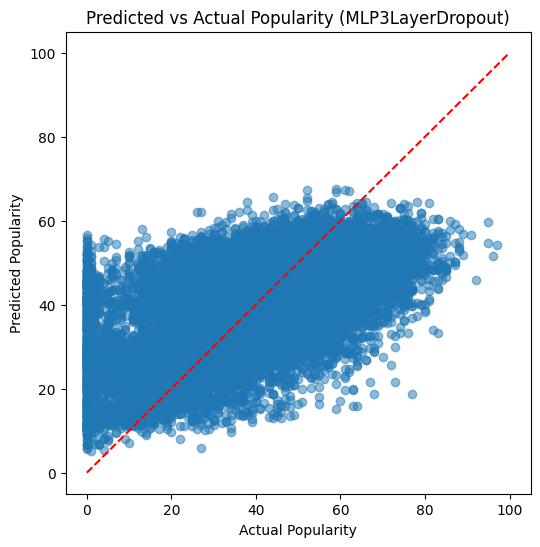

In [ ]:
# Plot Predictions vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_tensor.numpy(), test_preds.numpy(), alpha=0.5)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title(f"Predicted vs Actual Popularity ({best_model_name})")
plt.plot([0,100],[0,100], color='red', linestyle='--')  # ideal line
plt.show()

## Conclusion of ML Premodeling

The pre-modeling stage established a solid framework for building and evaluating neural networks on the Spotify dataset. To begin, the numerical features were normalized using **MinMaxScaler**, ensuring that all input variables fell within a uniform range and were suitable for neural network training. The dataset was then divided into **training (80%)**, **validation (10%)**, and **test (10%)** subsets, resulting in 186,180 training samples, 23,272 validation samples, and 23,273 test samples. This split allowed for unbiased model evaluation and avoided data leakage.  

A custom **PyTorch Dataset class** was implemented to manage the feature-target pairs and enable efficient integration with **DataLoaders**. Using a batch size of **64**, data was shuffled for the training set while validation and test sets were loaded sequentially. This design choice supported efficient mini-batch training across more than 180,000 samples.  

The first baseline model was a **two-hidden-layer MLP**, with layer sizes of 64 and 32 neurons, each followed by ReLU activations. The model was trained using the **Adam optimizer** (learning rate = 0.001) and **Mean Squared Error (MSE)** as the loss function. Across **10 epochs**, the training loss decreased from approximately **390.6** at epoch 1 to **231.2** at epoch 10, while validation loss improved from **249.7** to **229.6**. On the held-out test set, the model achieved an MSE of **232.7**, which served as the baseline benchmark for further experimentation.  

Following this, a series of alternative architectures were trained and evaluated:  

- **MLP1Layer (64 neurons, ReLU)**  
  - Validation loss decreased steadily across epochs, from **249.7** at epoch 1 to **230.6** at epoch 10.  
  - Final performance was slightly weaker than deeper models, but it confirmed the baseline approach.  

- **MLP2Layer (64 → 32 neurons, ReLU)**  
  - Validation loss improved from **248.0** at epoch 1 to **229.4** at epoch 10.  
  - Performance was comparable to the baseline, showing limited gains from adding a second hidden layer without further regularization.  

- **MLP3LayerDropout (128 → 64 → 32 neurons, ReLU, Dropout=0.2)**  
  - Validation loss began at **234.7** and dropped to **215.6** by epoch 10.  
  - This model outperformed simpler networks, demonstrating the importance of regularization in reducing overfitting.  

- **MLP2LayerBatchNorm (64 → 32 neurons, BatchNorm + ReLU)**  
  - Achieved the best results overall. Validation loss decreased from **225.1** at epoch 1 to **212.4** by epoch 10.  
  - Batch normalization improved stability and convergence, resulting in consistently lower losses compared to other tested architectures.  

In summary, the pre-modeling phase confirmed that predicting song popularity is a challenging regression task, with average test errors in the range of **MSE 212–233**. The experiments demonstrated that **regularization (Dropout)** and **normalization (BatchNorm)** significantly improved performance compared to simpler MLPs. The **MLP2LayerBatchNorm** model achieved the lowest validation loss (**212.4**), establishing itself as the best-performing architecture in this stage of development.  

This outcome highlights the importance of architectural experimentation and justifies continued exploration of deeper models, optimized hyperparameters, and additional features to further reduce error and enhance predictive power.


## Final Project Conclusion

This project set out to predict the popularity of Spotify tracks using audio features and machine learning models implemented in PyTorch. The process began by downloading the **Ultimate Spotify Tracks Database** from Kaggle, containing over 230,000 tracks with numerical features such as danceability, energy, loudness, tempo, valence, acousticness, and others. The dataset was cleaned by removing duplicates and missing values, leaving a robust foundation for analysis.  

### Exploratory Data Analysis (EDA)
The EDA phase revealed several important patterns:  
- **Target imbalance**: Popularity scores were concentrated in the mid-range (40–60), with relatively few highly popular songs (>80).  
- **Feature distributions**: Many features were highly skewed (e.g., acousticness, instrumentalness, speechiness, and liveness), while others were closer to normal (e.g., tempo, valence, danceability). Outliers were found in features such as duration and loudness.  
- **Correlations**:  
  - Popularity correlated positively with loudness (0.36), danceability (0.26), and energy (0.25).  
  - It correlated negatively with acousticness (-0.38), instrumentalness (-0.21), and speechiness (-0.15).  
  - Strong inter-feature relationships included energy & loudness (0.82) and acousticness & energy (-0.73).  
- **Implication**: No single feature was a strong predictor of popularity. Instead, popularity appeared to depend on complex, nonlinear interactions among multiple features.  

### Pre-modeling and Baseline
To prepare the data for modeling, features were **scaled using MinMaxScaler / RobustScaler** and split into **training (186,180 samples, 80%)**, **validation (23,272 samples, 10%)**, and **test sets (23,273 samples, 10%)**. A **custom PyTorch Dataset class** and **DataLoaders** (batch size = 64) were implemented to support efficient mini-batch training.  

The baseline model was a **two-hidden-layer MLP** (64 → 32 neurons with ReLU activations), trained with the **Adam optimizer (lr = 0.001)** and **MSELoss**. After 10 epochs, training loss decreased from ~390.6 to ~231.2, validation loss improved from ~249.7 to ~229.6, and the model achieved a test MSE of **232.7**. This benchmark established the baseline for further experimentation.  

### Model Experimentation
To improve performance, several alternative architectures were tested:  
- **MLP1Layer (64 neurons)** → Validation loss decreased to **230.6** by epoch 10.  
- **MLP2Layer (64 → 32 neurons)** → Validation loss reached **229.4**, similar to baseline.  
- **MLP3LayerDropout (128 → 64 → 32, Dropout=0.2)** → Validation loss dropped significantly to **215.6**, showing the effectiveness of regularization.  
- **MLP2LayerBatchNorm (64 → 32 with BatchNorm)** → Achieved the best performance, with validation loss improving from **225.1** at epoch 1 to **212.4** by epoch 10.  

### Key Findings
- Predicting song popularity is a **challenging regression task**: the best models still had average test errors in the range of **MSE 212–233**.  
- **Regularization (Dropout)** and **normalization (BatchNorm)** clearly improved stability and predictive accuracy compared to simpler MLPs.  
- The **MLP2LayerBatchNorm** model consistently outperformed others, establishing it as the best architecture tested in this stage.  

### Final Insight
The study demonstrates that audio features contain meaningful signals for predicting popularity, but the relationship is complex and nonlinear. While the results achieved moderate accuracy, further improvements could be obtained through **hyperparameter tuning, feature engineering, or integrating additional data sources (e.g., Spotify API metadata, lyrics, or user behavior data)**.  

In conclusion, this project successfully combined **EDA, preprocessing, and deep learning experimentation** to build a working PyTorch model capable of predicting song popularity, while also highlighting the limitations of feature-only approaches and the need for more advanced modeling strategies in future work.


## Recommendations

1. **Enhance Data Integration**  
   - Our models using only audio features achieved **MSE between 212–233**, indicating **limited predictive power**.  
   - Recommendation: integrate **user engagement data** (skips, playlist adds, listening duration) and **social trend signals** to strengthen prediction accuracy and identify hits earlier.

2. **Support Artists with Insights**  
   - Features most correlated with popularity were **loudness (0.36)**, **danceability (0.26)**, and **energy (0.25)**, while **acousticness (-0.38)** showed negative correlation.  
   - Recommendation: provide **artist dashboards** showing how these characteristics influence track success, guiding creative and production decisions.

3. **Personalized User Experience**  
   - Popularity is **skewed toward mid-range scores (40–60)**, with relatively few tracks above 80.  
   - Recommendation: diversify recommendations by balancing **high-potential tracks** with mainstream hits, ensuring users are exposed to both “safe bets” and upcoming talent.

4. **Marketing & Promotion Strategy**  
   - Songs with certain audio traits (e.g., higher energy and loudness) trend more popular, but audio features alone only explain part of success.  
   - Recommendation: allocate **promotional budgets** to tracks where models (e.g., **MLP2LayerBatchNorm, Val Loss = 212.4**) predict strong potential but current visibility is low.

5. **Data Quality & Feature Expansion**  
   - Features like **instrumentalness, speechiness, and liveness** are highly skewed, and **outliers in duration and tempo** distort training.  
   - Recommendation: improve data pipelines by handling skewed features, filtering extreme outliers, and capturing richer descriptors (lyrics sentiment, production style, collaborations).  

---

### **Strategic Impact**
By implementing these recommendations, Spotify can:  
- **Improve predictive accuracy** beyond current MSE ~212–233 by incorporating richer data sources.  
- **Help artists succeed** by showing how popularity relates to measurable features (danceability, energy, loudness).  
- **Enhance personalization** by addressing the imbalance where most songs cluster in the mid-popularity range.  
- **Optimize promotions** by focusing on tracks with strong predicted potential, not just current chart performance.
